**Introduction**

This notebook is a simple attempt to show how far you can go with CatBoost using only the basics: imputing missing values and applying an ordinal encoder for categorical features.

CatBoost handles much of the heavy lifting internally, so there’s no extensive preprocessing, feature scaling, or complex ensembling involved here. **At the time of writing, this setup achieves a score of about 0.1196 on the public Leader Board (233).**

# **Important Libraries**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# **Load Data**

In [16]:
df = pd.read_csv("data/train.csv", keep_default_na=False)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


# **EDA**

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1460 non-null   int64 
 1   MSSubClass     1460 non-null   int64 
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1460 non-null   object
 4   LotArea        1460 non-null   int64 
 5   Street         1460 non-null   object
 6   Alley          1460 non-null   object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64 
 18  OverallCond    1460 non-null

In [18]:
df.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


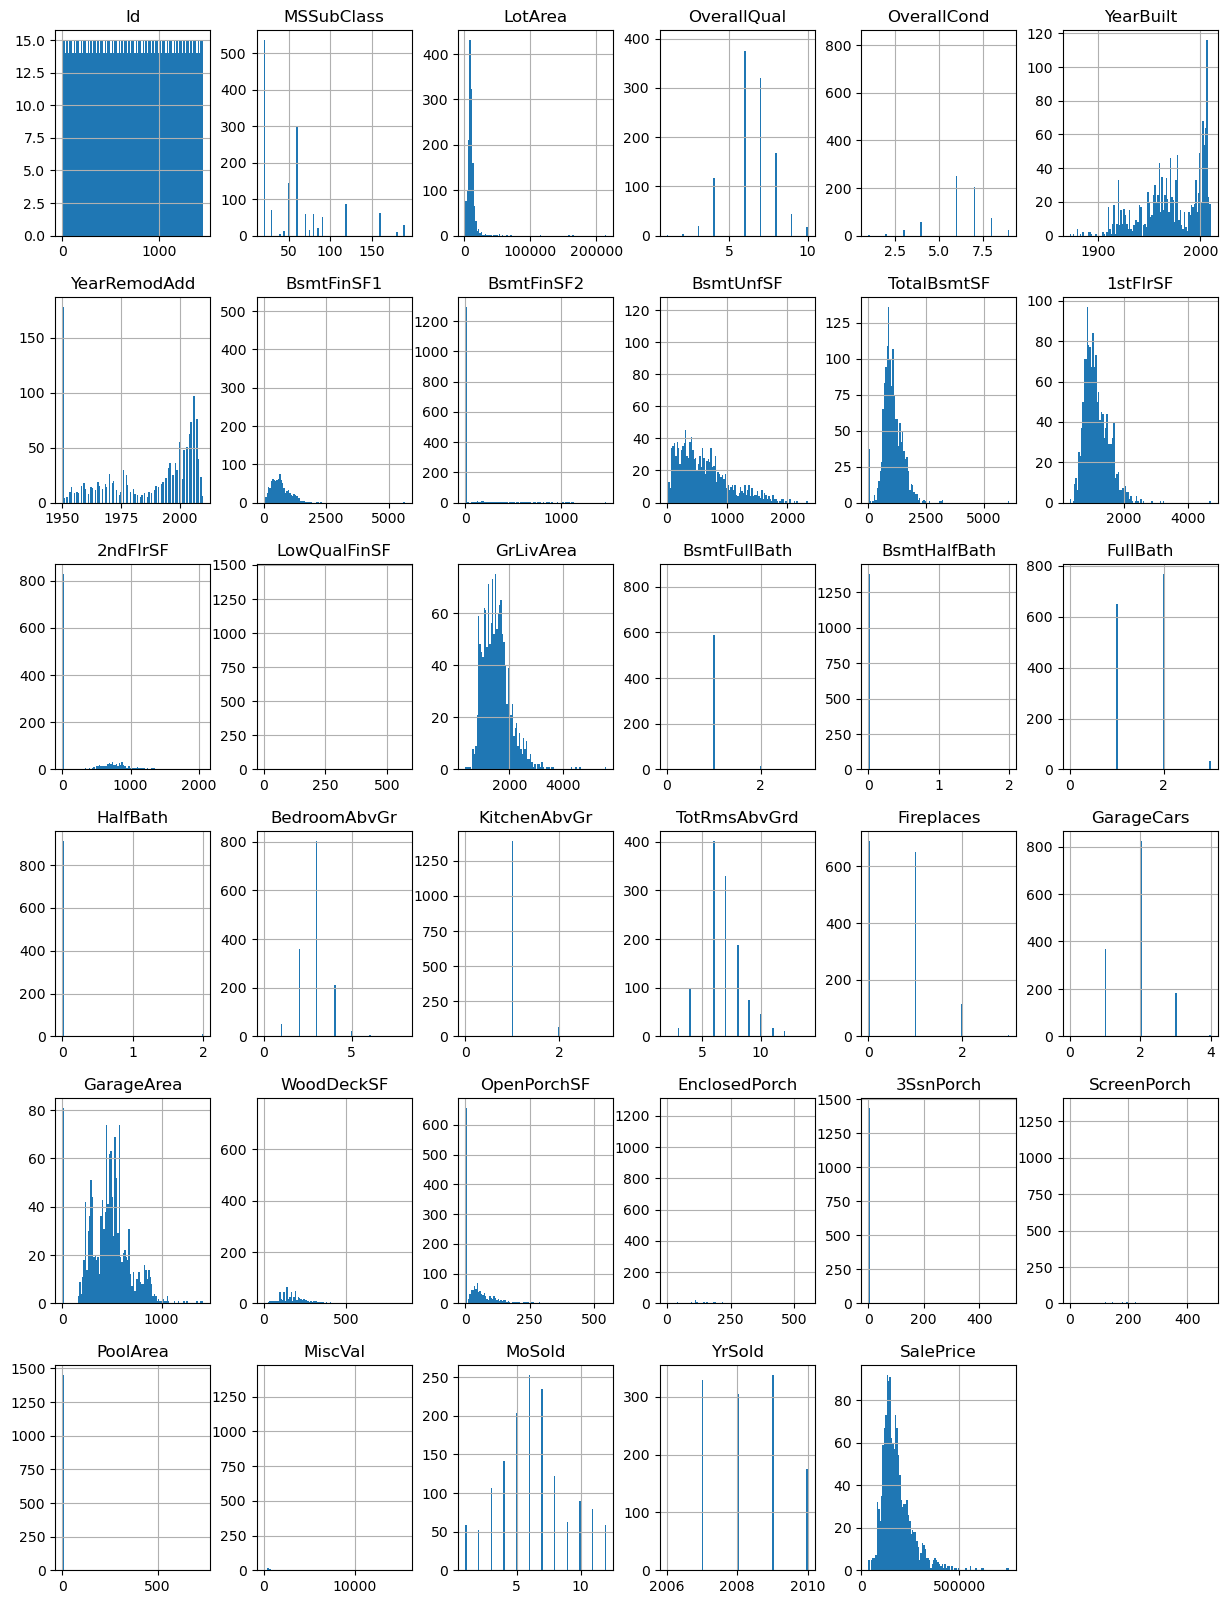

In [19]:
df.hist(bins=100,figsize=(15,20))
plt.show()

In [20]:
# Numerical features — confirmed from dataset column names
numerical_cols = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'GrLivArea', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'MoSold',
    'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'OverallQual', 'OverallCond'
]

# Ordinal columns with their order preserved
ordinal_map = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['NA', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['NA', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}
ordinal_cols = list(ordinal_map.keys())

# Nominal (non-ordinal) categorical features — matched to real names
nominal_cols = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
    'CentralAir', 'Electrical', 'GarageType', 'MiscFeature',
    'SaleType', 'SaleCondition'
]

In [21]:
y = df["SalePrice"] # Identify Target Variable
df = df.drop(columns=["SalePrice", "Id"])  # Drop ID 

missing_like = ['NA', 'N/A', 'na', 'n/a', 'NaN', 'nan', 'None', 'none', '', ' ']

In [22]:
# Clean and Impute Numerical Cols
for col in numerical_cols:
    df[col] = df[col].replace(missing_like, np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())

In [23]:
# Encode ordinal columns 
ordinal_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1,
    categories=[[str(cat) for cat in ordinal_map[col]] for col in ordinal_cols]
)
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols].astype(str))

In [24]:
# Inpute Nominal columns and fill missing
for col in nominal_cols:
    if col in df.columns:
        df[col] = df[col].replace(missing_like, 'missing')
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')

In [ ]:
cat_cols = nominal_cols  # Nominal features only for CatBoost

Note: Any EDA steps and imputations applied to the training data must also be consistently applied to the test data; this ensures the model receives data in the same format during prediction, preventing errors or mismatches.

In [25]:
df_test = pd.read_csv("data/test.csv", keep_default_na=False)
final_df = df_test[["Id"]] # This Frame will be our final result after modeling

In [4]:
# Numerical columns
for col in numerical_cols:
    if col in df_test.columns:
        df_test[col] = df_test[col].replace(missing_like, np.nan)
        df_test[col] = pd.to_numeric(df_test[col], errors='coerce')
        median_val = df[col].median()  # use median from training data
        df_test[col] = df_test[col].fillna(median_val)

df_test = df_test[df.columns]  # X is your original train set (post-processing)

In [ ]:
# Ordinal columns
for col in ordinal_cols:
    if col in df_test.columns:
        df_test[col] = df_test[col].replace(missing_like, 'missing')
        df_test[col] = df_test[col].fillna('missing')

df_test[ordinal_cols] = ordinal_encoder.transform(df_test[ordinal_cols].astype(str))

In [26]:
# Nominal categorical columns
for col in nominal_cols:
    if col in df_test.columns:
        df_test[col] = df_test[col].replace(missing_like, 'missing')
        df_test[col] = df_test[col].astype('category')

In [27]:
df_test = df_test[df.columns]  # df is your original train set (post-processing)

# **Modeling**

In [29]:
model = CatBoostRegressor(silent=True, random_state=42)

In [28]:
# Hyper Parameters for our random search cross validation
param_dist = {
    'depth': [4, 10],
    'learning_rate': [0.01, 0.2],
    'iterations': [300, 1500],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128]
}

cat_cols = [col for col in nominal_cols if col in df.columns] # We only use nominal cols as category due to orindal encoding

In [ ]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,  # Adjust as needed
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1 ,
    verbose=100,
    random_state=42
)

In [ ]:
# Fit the model (CatBoost will internally handle categorical columns)
random_search.fit(df, y, cat_features=cat_features)

print("Best parameters:", random_search.best_params_)
print("Best RMSE score:", -random_search.best_score_)

In [ ]:
preds = random_search.predit(df_test)

In [ ]:
final_df["SalePrice"] = preds
final_df # Looking at predictions before exporting

In [ ]:
final_df.to_csv("predicted_sales_prices.csv", index=False)